In [454]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

pd.set_option('display.max_rows', 10)
%matplotlib inline

### Load data

Text(0,0.5,'waiting')

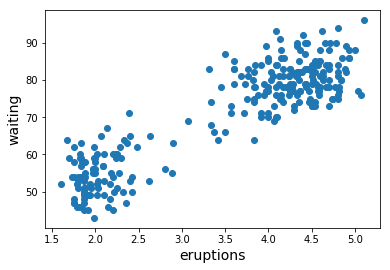

In [2]:
data = pd.read_csv('data/data.csv')
plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
plt.xlabel(data.columns[0], fontsize=14)
plt.ylabel(data.columns[1], fontsize=14)

### Scale data to 0 ~ 1

In [372]:
scaler = MinMaxScaler()
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=data.columns)
display(data_scaled)

,eruptions,waiting
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453
...,...,...
267,0.719143,0.716981
268,0.157143,0.056604
269,0.804857,0.886792
270,0.062000,0.056604


### Gaussian Mixture Model - Expection Maximization Algorithm

In [494]:
class GMM_EM:
    def __init__(self, K, data, threshold=10e-4):
        self.K = K
        self.data = data
        self.num_data, self.num_features = self.data.shape
        self.threshold = threshold
       
        
    def __get_init_params(self):
        mu = np.random.rand(self.K, self.num_features)
        cov_rand = np.random.rand(self.K)
        cov = []
        for rand in cov_rand:
            cov.append(np.diag([rand, rand]))
        cov = np.array(cov)
        
        pi = []
        remain = 1
        pi_rand = np.random.rand(self.K - 1)
        for rand in pi_rand:
            pi.append(rand)
            remain -= rand * remain
        pi.append(remain)
        pi = np.array(pi)
        return mu, cov, pi

    
    def __get_expectation(self, mu, cov, pi):
        # Calculate probabilities for all samples to each model
        prob = np.zeros((self.num_data, self.K))
        for k in range(self.K):
            prob[:, k] = multivariate_normal.pdf(self.data, mean=mu[k], cov=cov[k])
        
        # Calculate responsibility for each model to every sample
        resp = np.zeros((self.num_data, self.K))
        for k in range(self.K):
            resp[:, k] = pi[k] * prob[:, k]
        for i in range(self.num_data):
            summ = np.sum(resp[i, :])
            if summ != 0:
                resp[i, :] /= summ
        
        return resp
        
        
    def __maximize(self, resp):
        mu = np.zeros((self.K, self.num_features))
        cov = []
        pi = np.zeros(self.K)

        # Update parameters for every model 
        for k in range(self.K):
            # sum of responses of all samples for kth model
            sum_resp = np.sum(resp[:, k])
    
            # mean  
            for f in range(self.num_features):
                mu[k, f] = np.sum(np.multiply(resp[:, k], self.data[:, f])) / sum_resp
            
            # cov (spherical)
            cov_k = 0
            for i in range(self.num_data):
                cov_k += resp[i, k] * np.sum(np.square(self.data[i] - mu[k]))
            
            cov_k /= sum_resp
            cov.append(np.diag([cov_k, cov_k]))
            
            # pi
            pi[k] = sum_resp / self.num_data
            
        return mu, cov, pi
        
    
    def __append_mu(self, mus, mu):
        for i in range(self.K):
            for j in range(self.num_features):
                mus[i][j].append(mu[i][j])
        
        
    def run(self, init_mu=None, init_cov=None):
        mu, cov, pi = self.__get_init_params()
        if init_mu is not None:
            mu = init_mu
        if init_cov is not None:
            cov = init_cov
        
        print("-------------------------------------------------------")
        print("Parameters initialized:","mu:", mu, "cov:", cov, "pi:", pi, sep="\n")
        
        mus = [[[] for _ in range(self.num_features)] for __ in range(self.K)]
        self.__append_mu(mus, mu)
        iterations = 0
        log_likelyhoods = []
        while iterations < 500:
            resp = self.__get_expectation(mu, cov, pi)
            mu, cov, pi = self.__maximize(resp)
            self.__append_mu(mus, mu)
            iterations += 1
            
            log_likelyhood = np.zeros(self.num_data)
            for k in range(self.K):
                log_likelyhood += multivariate_normal.pdf(self.data, mean=mu[k], cov=cov[k]) * pi[k]
            
            log_likelyhood = np.sum(np.log10(log_likelyhood))
            log_likelyhoods.append(log_likelyhood)
        
            # noise resistance
            if iterations > 5 and \
               abs(np.mean(log_likelyhoods[iterations - 2 : iterations]) - \
                   np.mean(log_likelyhoods[iterations - 5 : iterations - 2])) \
               / abs(log_likelyhoods[-1]) < 10e-5:
                break
            
#         plt.figure()
#         plt.plot(log_likelyhoods)
#         plt.show
            
        return mus, iterations

-------------------------------------------------------
Parameters initialized:
mu:
[[0.28319668 0.95669096]
 [0.21760345 0.79058982]]
cov:
[[[0.80870404 0.        ]
  [0.         0.80870404]]

 [[0.83376875 0.        ]
  [0.         0.83376875]]]
pi:
[0.66139125 0.33860875]
Done with 34 iterations.


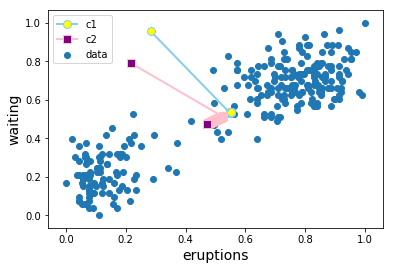

In [495]:
model = GMM_EM(2, data_scaled.values)
mus, iters = model.run()

print("Done with", iters, "iterations.")

mus1 = pd.DataFrame({data.columns[0]: mus[0][0], data.columns[1]: mus[0][1]})
mus2 = pd.DataFrame({data.columns[0]: mus[1][0], data.columns[1]: mus[1][1]})

plt.figure()
plt.scatter(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], label="data", alpha=1)
plt.xlabel(data.columns[0], fontsize=14)
plt.ylabel(data.columns[1], fontsize=14)
plt.plot(data.columns[0], data.columns[1], data=mus1, label='c1', marker='o', markerfacecolor='yellow', markersize=8, color='skyblue', linewidth=2)
plt.plot(data.columns[0], data.columns[1], data=mus2, label='c2', marker='s', markerfacecolor='purple', markersize=8, color='pink', linewidth=2)
plt.legend()

-------------------------------------------------------
Parameters initialized:
mu:
[[0.98334917 0.05595962]
 [0.50166794 0.86884552]]
cov:
[[[0.47998186 0.        ]
  [0.         0.47998186]]

 [[0.86358129 0.        ]
  [0.         0.86358129]]]
pi:
[0.16743257 0.83256743]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.18803557 0.34768476]
 [0.65274647 0.6342673 ]]
cov:
[[[0.22030573 0.        ]
  [0.         0.22030573]]

 [[0.37860269 0.        ]
  [0.         0.37860269]]]
pi:
[0.39075996 0.60924004]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.24615278 0.42300433]
 [0.78712963 0.09721281]]
cov:
[[[0.52308576 0.        ]
  [0.         0.52308576]]

 [[0.01013392 0.        ]
  [0.         0.01013392]]]
pi:
[0.32107982 0.67892018]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.92307896 0.47359733]
 [0.57452391 0.7681914 ]]
cov:
[[[0.12405073 0.        ]
  [0. 

-------------------------------------------------------
Parameters initialized:
mu:
[[0.12628854 0.5889554 ]
 [0.53740675 0.91906549]]
cov:
[[[0.48387405 0.        ]
  [0.         0.48387405]]

 [[0.24735889 0.        ]
  [0.         0.24735889]]]
pi:
[0.87260922 0.12739078]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.06488713 0.72516081]
 [0.02676025 0.31110488]]
cov:
[[[0.73159103 0.        ]
  [0.         0.73159103]]

 [[0.4052656  0.        ]
  [0.         0.4052656 ]]]
pi:
[0.24115105 0.75884895]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.32469773 0.92346596]
 [0.23139952 0.81895357]]
cov:
[[[0.52656607 0.        ]
  [0.         0.52656607]]

 [[0.17807747 0.        ]
  [0.         0.17807747]]]
pi:
[0.62138258 0.37861742]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.5916482  0.09100924]
 [0.4855946  0.78063685]]
cov:
[[[0.10600793 0.        ]
  [0. 

(array([0., 0., 0., 0., 0., 0., 7., 0., 0., 1., 0., 1., 1., 1., 2., 5., 3.,
        1., 5., 3., 2., 0., 0., 1., 1., 0., 0., 2., 1., 0., 2., 1., 0., 2.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 2., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]),
 <a list of 81 Patch objects>)

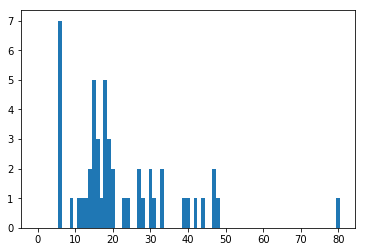

In [579]:
conv_iters = []
model = GMM_EM(2, data_scaled.values)
for _ in range(50):
    mus, iters = model.run()
    conv_iters.append(iters)

plt.hist(conv_iters, bins=range(max(conv_iters) + 1), align='left', rwidth=1)

### Use k-means to get initial guess

array([[0.12818076, 0.21967655],
       [0.77095402, 0.69908913]])

[array([[0.00663548, 0.0032339 ],
        [0.0032339 , 0.01278108]]), array([[0.01314781, 0.00455613],
        [0.00455613, 0.01261538]])]

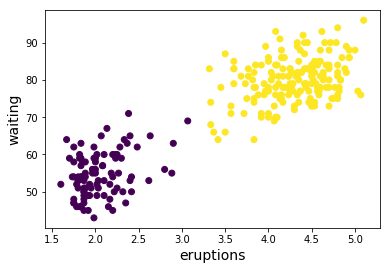

In [576]:
def run_kmeans(show=False):
    kmeans = KMeans(n_clusters=2, random_state=33).fit(data_scaled)
    pred = kmeans.predict(data_scaled)
    
    c1 = data_scaled[pred==0].values
    c2 = data_scaled[pred==1].values

    mu = kmeans.cluster_centers_
    cov = [np.cov(c1, rowvar=False), np.cov(c2, rowvar=False)]
    
    if show:
        display(mu)
        display(cov)

        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=pred)
        plt.xlabel(data.columns[0], fontsize=14)
        plt.ylabel(data.columns[1], fontsize=14)
    
    return mu, cov

run_kmeans(True);

-------------------------------------------------------
Parameters initialized:
mu:
[[0.12818076 0.21967655]
 [0.77095402 0.69908913]]
cov:
[array([[0.00663548, 0.0032339 ],
       [0.0032339 , 0.01278108]]), array([[0.01314781, 0.00455613],
       [0.00455613, 0.01261538]])]
pi:
[0.11724105 0.88275895]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.12818076 0.21967655]
 [0.77095402 0.69908913]]
cov:
[array([[0.00663548, 0.0032339 ],
       [0.0032339 , 0.01278108]]), array([[0.01314781, 0.00455613],
       [0.00455613, 0.01261538]])]
pi:
[0.9092237 0.0907763]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.12818076 0.21967655]
 [0.77095402 0.69908913]]
cov:
[array([[0.00663548, 0.0032339 ],
       [0.0032339 , 0.01278108]]), array([[0.01314781, 0.00455613],
       [0.00455613, 0.01261538]])]
pi:
[0.44397281 0.55602719]
-------------------------------------------------------
Parameters initialized:
mu:
[[0

-------------------------------------------------------
Parameters initialized:
mu:
[[0.12818076 0.21967655]
 [0.77095402 0.69908913]]
cov:
[array([[0.00663548, 0.0032339 ],
       [0.0032339 , 0.01278108]]), array([[0.01314781, 0.00455613],
       [0.00455613, 0.01261538]])]
pi:
[0.96461316 0.03538684]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.12818076 0.21967655]
 [0.77095402 0.69908913]]
cov:
[array([[0.00663548, 0.0032339 ],
       [0.0032339 , 0.01278108]]), array([[0.01314781, 0.00455613],
       [0.00455613, 0.01261538]])]
pi:
[0.28778728 0.71221272]
-------------------------------------------------------
Parameters initialized:
mu:
[[0.12818076 0.21967655]
 [0.77095402 0.69908913]]
cov:
[array([[0.00663548, 0.0032339 ],
       [0.0032339 , 0.01278108]]), array([[0.01314781, 0.00455613],
       [0.00455613, 0.01261538]])]
pi:
[0.95748432 0.04251568]
-------------------------------------------------------
Parameters initialized:
mu:
[

(array([ 0.,  0.,  0.,  0.,  0.,  0., 22., 28.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

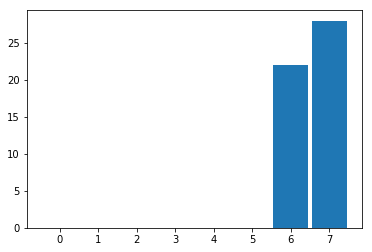

In [584]:
conv_iters = []
model = GMM_EM(2, data_scaled.values)
for _ in range(50):
    init_mu, init_cov = run_kmeans()
    mus, iters = model.run(init_mu, init_cov)
    conv_iters.append(iters)

plt.hist(conv_iters, bins=range(max(conv_iters) + 2), align='left', rwidth=0.9)